# Logistic Regression Assignment

We are given a dataset of  direct marketing campaigns of a credit institution. **Our goal is to implement a model to predict whether the client will subscribe to a term deposit.**

**When working on the assignment there could be multiple ways to explore data or implement specific analysis. Choose that one you retain more appropriate but always justify every choice you make (e.g., why you choose some variables), comment your code, describe the plots and results you obtain.**


### Enjoy!

DATASET DESCRIPTION

- age (numeric)
- job : type of job 
- marital : marital status
- education 
- default: has credit in default? 
- housing: has housing loan? 
- loan: has personal loan? 
- contact: contact communication type 
- month: last contact month of year 
- day_of_week: last contact day of the week 
- duration: last contact duration, in seconds (numeric). Important note: this attribute highly affects the output target (e.g., if duration=0 then y=’no’). The duration is not known before a call is performed, also, after the end of the call, y is obviously known. Thus, this input should only be included for benchmark purposes and should be discarded if the intention is to have a realistic predictive model
- campaign: number of contacts performed during this campaign and for this client 
- pdays: number of days that passed by after the client was last contacted from a previous campaign (999 means client was not previously contacted)
- previous: number of contacts performed before this campaign and for this client (numeric)
- poutcome: outcome of the previous marketing campaign 
- emp.var.rate: employment variation rate 
- cons.price.idx: consumer price index 
- cons.conf.idx: consumer confidence index 
- euribor3m: euribor 3 month rate 
- nr.employed: number of employees 
- y — Target variable: has the client subscribed a term deposit? 

##### Import libraries

In [1]:
import pandas as pd
import numpy as np
from sklearn import preprocessing
import matplotlib.pyplot as plt 
plt.rc("font", size=18)
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
import seaborn as sns

sns.set(style="white")
sns.set(style="whitegrid", color_codes=True)

In [2]:
data = pd.read_csv('banking.csv')
data.head(3)

,age,job,marital,education,default,housing,loan,contact,month,day_of_week,...,campaign,pdays,previous,poutcome,emp_var_rate,cons_price_idx,cons_conf_idx,euribor3m,nr_employed,y
0,44,blue-collar,married,basic.4y,unknown,yes,no,cellular,aug,thu,...,1,999,0,nonexistent,1.4,93.444,-36.1,4.963,5228.1,0
1,53,technician,married,unknown,no,no,no,cellular,nov,fri,...,1,999,0,nonexistent,-0.1,93.200,-42.0,4.021,5195.8,0
2,28,management,single,university.degree,no,yes,no,cellular,jun,thu,...,3,6,2,success,-1.7,94.055,-39.8,0.729,4991.6,1


In [3]:
data.shape

(41188, 21)

## EDA and Feature Engineering 

An important requirement for Logistic Regression to function properly is Feature Engineering as it helps to identify independent variables. Without proper identification of independent variables Logistic Regression fails to perform correctly.

One disadvantage of logistic regression is that it doesn’t handle large number of categorical variables well.

```education``` column has many categories, try to reduce the categories for a better modelling. The education column has the following categories.


In [4]:
data.education.unique()

array(['basic.4y', 'unknown', 'university.degree', 'high.school',
       'basic.9y', 'professional.course', 'basic.6y', 'illiterate'],
      dtype=object)

We will group all ```basic.XX``` in a unique value ```basic```

In [5]:

def education_subs(educ):
    educ=re.sub('basic.4y','basic',educ)
    educ=re.sub('basic.9y','basic',educ)
    educ=re.sub('basic.6y','basic',educ)
    return educ

In [6]:
import re

data['educ_clean']=data['education'].apply(lambda x:education_subs(x))

In [7]:
data.educ_clean.unique()

array(['basic', 'unknown', 'university.degree', 'high.school',
       'professional.course', 'illiterate'], dtype=object)

##### Analyse the distribution of the target variable

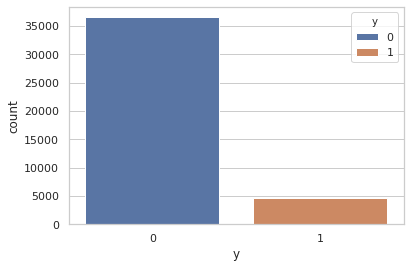

In [8]:
sns.countplot('y',data=data,hue='y',dodge=False)

In [9]:
pd.crosstab(data.y,columns='y',values=data.job,aggfunc='count',normalize=True).round(2)


col_0,y
y,
0,0.89
1,0.11


In [10]:
counts=pd.DataFrame(data['y'].value_counts())
counts['perc']=counts['y'].apply(lambda x: x*100/counts.y.sum()).round(2)
counts

,y,perc
0,36548,88.73
1,4640,11.27


##### What can we observe about the distribution of the target variable

Reply here...

By the moment we can observe that the majority of the cases people dont accept a term deposit. But still selling a deposit one each 10 calls could be a really good conversion rate. The important would be understan who are the ones who has mos the chances to accept it, so this conversion rate coul be higher

Other important thing is that the categories are not balanced, so we count with almost a 90% of the observations as NO. The model will struggle to preditc a Yes under this conditions.

##### Observe how the different numeric variables behave for the 2 classes

In [11]:
data.groupby('y').mean()

,age,duration,campaign,pdays,previous,emp_var_rate,cons_price_idx,cons_conf_idx,euribor3m,nr_employed
y,,,,,,,,,,
0,39.911185,220.844807,2.633085,984.113878,0.132374,0.248875,93.603757,-40.593097,3.811491,5176.166600
1,40.913147,553.191164,2.051724,792.035560,0.492672,-1.233448,93.354386,-39.789784,2.123135,5095.115991


Observations:
- Clients that accept term deposit are in average one year older
- The duration of the calls are double when they accept, so as the conversation is increasing we can be thinking that the probability of selling the deposit will increase
- It is observe that the main contact for selling the deposit is 2, so after the second call we can think that probabilities of sell the deposit will start to decrease

##### Analyse other variables - Make some plots and discuss them

- **Job title**

[Text(0, 0, 'blue-collar'),
 Text(0, 0, 'technician'),
 Text(0, 0, 'management'),
 Text(0, 0, 'services'),
 Text(0, 0, 'retired'),
 Text(0, 0, 'admin.'),
 Text(0, 0, 'housemaid'),
 Text(0, 0, 'unemployed'),
 Text(0, 0, 'entrepreneur'),
 Text(0, 0, 'self-employed'),
 Text(0, 0, 'unknown'),
 Text(0, 0, 'student')]

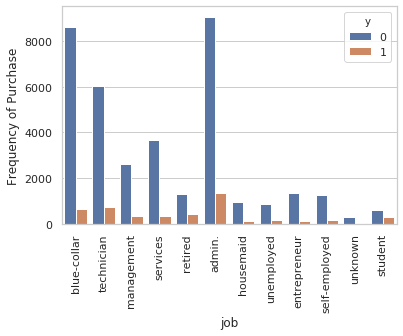

In [12]:
ax=sns.countplot('job',data=data,hue='y')
ax.set_ylabel('Frequency of Purchase')
ax.set_xticklabels(ax.get_xticklabels(),rotation=90)

In [14]:
job_perc=pd.crosstab(data.job,data.y,normalize='index').round(2)
job_perc

y,0,1
job,,
admin.,0.87,0.13
blue-collar,0.93,0.07
entrepreneur,0.91,0.09
housemaid,0.90,0.10
management,0.89,0.11
retired,0.75,0.25
self-employed,0.90,0.10
services,0.92,0.08
student,0.69,0.31


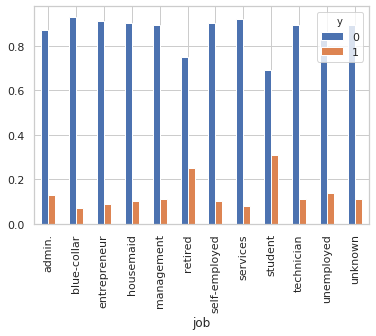

In [15]:
job_perc.plot.bar()

- Comment the plots

So it looks that the most of the person that were called are admin blue collar or technicians, but the ones that has the most probabilities to buy are students and retired people

- **Marital status**

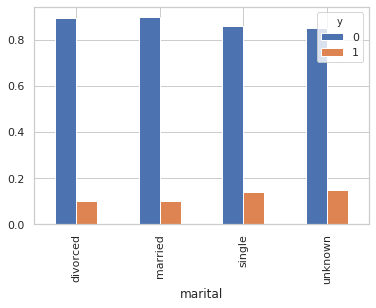

In [16]:
pd.crosstab(data.marital,data.y,normalize='index').plot.bar()

- Comment the plots

by seeing this plot we can assume that the odds of accepting the deposit insnt affected by marital status

- **Education**

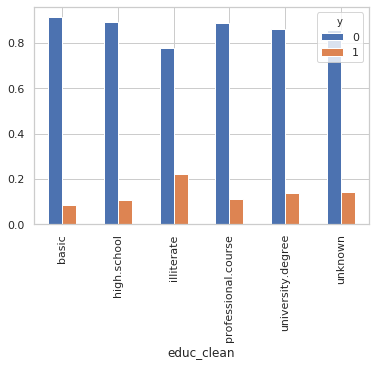

In [17]:
pd.crosstab(data.educ_clean,data.y,normalize='index').plot(kind='bar')

- Comment the plots

Average probabilities of buying the deposit doubles when people is illiterate, after that the odds looks barely the same

- **Day of Week**

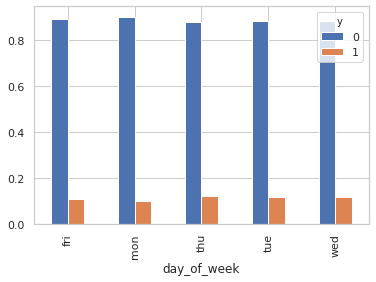

In [18]:
pd.crosstab(data.day_of_week,data.y,normalize='index').plot.bar()

- Comment the plots

The day in the week doesnt seems to be really important ate the moment of predict the probability of purchasing the product. Just thursdays looks a little better, but that cuould be for others factors aswell taking in count that the difference is not really important

- **Month**

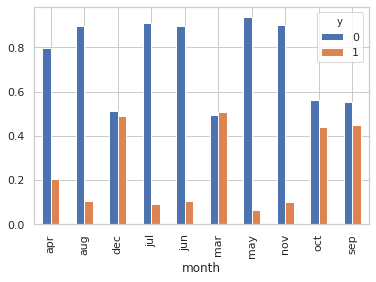

In [19]:
pd.crosstab(data.month,data.y,normalize='index').plot.bar()

- Comment the plots

This plot shows that the season does really matters, people buy more products during mar-oct-sep-dec and apr. So this product could be a seasonal one.

- **poutcome**

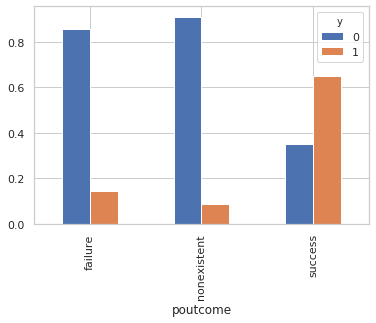

In [20]:
pd.crosstab(data.poutcome,data.y,normalize='index').plot.bar()

- Comment the plots

People who already made a purchase have more than 3x chance to buy again

# Some other variables

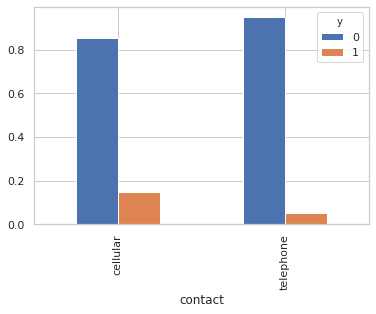

In [21]:
pd.crosstab(data.contact,data.y,normalize='index').plot.bar()

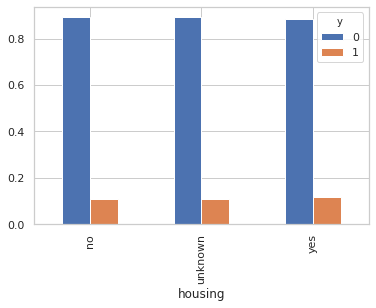

In [22]:
pd.crosstab(data.housing,data.y,normalize='index').plot.bar()

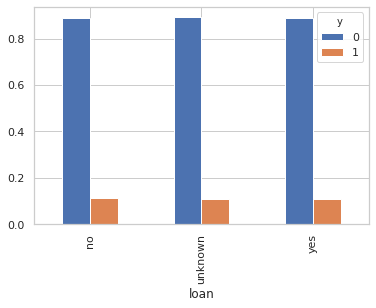

In [23]:
pd.crosstab(data.loan,data.y,normalize='index').plot.bar()

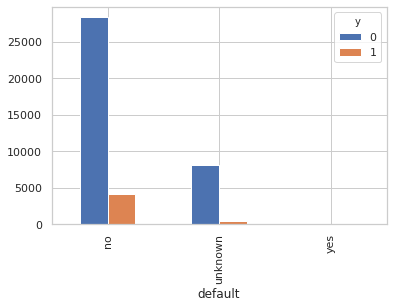

In [24]:
pd.crosstab(data.default,data.y).plot.bar()

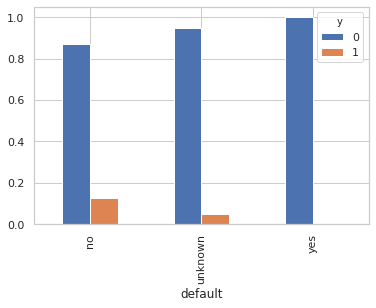

In [25]:
pd.crosstab(data.default,data.y,normalize='index').plot.bar()

### Create dummy variables

In [1]:
# Put your code here

In [26]:
data=data.drop('education',axis=1)

In [27]:
data.head()

,age,job,marital,default,housing,loan,contact,month,day_of_week,duration,...,pdays,previous,poutcome,emp_var_rate,cons_price_idx,cons_conf_idx,euribor3m,nr_employed,y,educ_clean
0,44,blue-collar,married,unknown,yes,no,cellular,aug,thu,210,...,999,0,nonexistent,1.4,93.444,-36.1,4.963,5228.1,0,basic
1,53,technician,married,no,no,no,cellular,nov,fri,138,...,999,0,nonexistent,-0.1,93.200,-42.0,4.021,5195.8,0,unknown
2,28,management,single,no,yes,no,cellular,jun,thu,339,...,6,2,success,-1.7,94.055,-39.8,0.729,4991.6,1,university.degree
3,39,services,married,no,no,no,cellular,apr,fri,185,...,999,0,nonexistent,-1.8,93.075,-47.1,1.405,5099.1,0,high.school
4,55,retired,married,no,yes,no,cellular,aug,fri,137,...,3,1,success,-2.9,92.201,-31.4,0.869,5076.2,1,basic


In [28]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 41188 entries, 0 to 41187
Data columns (total 21 columns):
age               41188 non-null int64
job               41188 non-null object
marital           41188 non-null object
default           41188 non-null object
housing           41188 non-null object
loan              41188 non-null object
contact           41188 non-null object
month             41188 non-null object
day_of_week       41188 non-null object
duration          41188 non-null int64
campaign          41188 non-null int64
pdays             41188 non-null int64
previous          41188 non-null int64
poutcome          41188 non-null object
emp_var_rate      41188 non-null float64
cons_price_idx    41188 non-null float64
cons_conf_idx     41188 non-null float64
euribor3m         41188 non-null float64
nr_employed       41188 non-null float64
y                 41188 non-null int64
educ_clean        41188 non-null object
dtypes: float64(5), int64(6), object(10)
memory usag

In [29]:
data=pd.get_dummies(data,columns=['job','educ_clean','month','poutcome','contact'],drop_first=True)
data.head()

,age,marital,default,housing,loan,day_of_week,duration,campaign,pdays,previous,...,month_jul,month_jun,month_mar,month_may,month_nov,month_oct,month_sep,poutcome_nonexistent,poutcome_success,contact_telephone
0,44,married,unknown,yes,no,thu,210,1,999,0,...,0,0,0,0,0,0,0,1,0,0
1,53,married,no,no,no,fri,138,1,999,0,...,0,0,0,0,1,0,0,1,0,0
2,28,single,no,yes,no,thu,339,3,6,2,...,0,1,0,0,0,0,0,0,1,0
3,39,married,no,no,no,fri,185,2,999,0,...,0,0,0,0,0,0,0,1,0,0
4,55,married,no,yes,no,fri,137,1,3,1,...,0,0,0,0,0,0,0,0,1,0


In [30]:
data.keys()

Index(['age', 'marital', 'default', 'housing', 'loan', 'day_of_week',
       'duration', 'campaign', 'pdays', 'previous', 'emp_var_rate',
       'cons_price_idx', 'cons_conf_idx', 'euribor3m', 'nr_employed', 'y',
       'job_blue-collar', 'job_entrepreneur', 'job_housemaid',
       'job_management', 'job_retired', 'job_self-employed', 'job_services',
       'job_student', 'job_technician', 'job_unemployed', 'job_unknown',
       'educ_clean_high.school', 'educ_clean_illiterate',
       'educ_clean_professional.course', 'educ_clean_university.degree',
       'educ_clean_unknown', 'month_aug', 'month_dec', 'month_jul',
       'month_jun', 'month_mar', 'month_may', 'month_nov', 'month_oct',
       'month_sep', 'poutcome_nonexistent', 'poutcome_success',
       'contact_telephone'],
      dtype='object')

In [31]:
dataf=data.copy()
dataf=dataf.drop(['marital','day_of_week','default','housing','loan'],axis=1)

In [32]:
dataf.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 41188 entries, 0 to 41187
Data columns (total 39 columns):
age                               41188 non-null int64
duration                          41188 non-null int64
campaign                          41188 non-null int64
pdays                             41188 non-null int64
previous                          41188 non-null int64
emp_var_rate                      41188 non-null float64
cons_price_idx                    41188 non-null float64
cons_conf_idx                     41188 non-null float64
euribor3m                         41188 non-null float64
nr_employed                       41188 non-null float64
y                                 41188 non-null int64
job_blue-collar                   41188 non-null uint8
job_entrepreneur                  41188 non-null uint8
job_housemaid                     41188 non-null uint8
job_management                    41188 non-null uint8
job_retired                       41188 non-null uint8
j

### Implement the Logistic Regression Model

In [33]:
from sklearn.linear_model import LogisticRegression
from sklearn import metrics


##### Prepare the dataset for training

In [34]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test= train_test_split(dataf.drop(['y'],axis=1),dataf.y,test_size=0.3,random_state=0)

print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)

(28831, 38)
(12357, 38)
(28831,)
(12357,)


In [35]:
logmodel=LogisticRegression()
logmodel.fit(X_train,y_train)

/home/alex/anaconda3/envs/bts36/lib/python3.6/site-packages/sklearn/linear_model/_logistic.py:939: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html.
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=None, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)

In [36]:
predictions=logmodel.predict(X_test)

##### Compute predictions and accuracy using the accuracy score provided by the sklearn library

In [37]:
# Put your code here
print('Accuracy of logistic regression classifier on test set: {:.2f}'.format(metrics.accuracy_score(y_test,predictions)))# Put your code here ))

Accuracy of logistic regression classifier on test set: 0.91


##### An accuracy of **91%** looks quite a good result, but have a look more in detail observing the confusion matrix and other metrics you consider interesting.


##### EXPLAIN WHY ACCURACY IS NOT ENOUGH TO EVALUATE THE PERFORMANCE OF A CLASSIFIER AND WHY IT MIGHT FAIL IN CASE OF IMBALANCED DATASET


Precision is measuring how much of the positive estimations where actually true. The problem with imbalanced dataset is that as there are already not much positive cases, precision could be really high but we can be missing other positive cases just predicting them like negative cases. 
In cases like this the better would be have a high recall.

Other problem is that the good way to predict the negative cases weight more in the total accuracy as they are the 90% of the dataset.

WRITE YOUR ANSWER HERE ...






The confusion matrics gives an interesting overview of how well a model is doing and it is a great starting point for any classification model evaluation.

![](https://skappal7.files.wordpress.com/2018/08/confusion-matrix.jpg?w=748)

In [38]:
mat=metrics.confusion_matrix(y_test,predictions)
mat

array([[10728,   253],
       [  844,   532]])

**Is our model obtaining good results or is it failing in some specific case?**

Reply here





As i said before, there are 844 true cases that we are not predicting. So recall is not even 50%. Thats really low. And in this case we need to predict positive cases so we can focus on call them!

##### Compute other metrics using classification report

In [41]:
from sklearn.metrics import classification_report

print(classification_report(y_test,predictions))

              precision    recall  f1-score   support

           0       0.93      0.98      0.95     10981
           1       0.68      0.39      0.49      1376

    accuracy                           0.91     12357
   macro avg       0.80      0.68      0.72     12357
weighted avg       0.90      0.91      0.90     12357



#### Remember:
    
**Precision:** percentage of your results which are relevant. Among all the elements that your model classify as positive, how many are really positive examples?
                                            $\frac{TP}{TP+FP}$
                                            

**Recall:** percentage of total relevant results correctly classified by your algorithm.
                                            $\frac{TP}{TP+FN}$                                            

In [43]:
532/(532+253) #Precision@1

0.6777070063694267

In [44]:
532/(844+532) #Recall@1

0.3866279069767442

## Imbalanced Classes

Imbalanced data typically refers to a problem with classification problems where the classes are not represented equally.


##### Explain why imbalanced data can be a problem 

Reply here...



Imbalanced data makes our algorithm to easly recognice one of the clases and struggle to recognize the other.



During the exploratory data analysis we have seen that we have **Imbalanced Classes**, i.e.,the percentage of negative examples is much higher with respect to the percentage of positiv examples. Indeed, observing the confusion matrix we saw that the implmented model face some problem in predict the positive examples (if a client will subscribe a term deposit).


##### To face this problem we will apply an over-sampling technique trying to balance our dataset generating **Synthetic Samples:** it consists in creating new synthetic points from the minority class to increase its cardinality.

we will use the **SMOTE** Algorithm [see here for more details](https://arxiv.org/pdf/1106.1813.pdf).

In order to apply SMOTE **install the imblearn python library** (if you already have it you do not need to reinstall):

[Follow this instructions](https://imbalanced-learn.readthedocs.io/en/stable/install.html)


### Now implent again the model following all the steps

Prepare the data

In [51]:
data_final=dataf.copy()
data_final.head()

,age,duration,campaign,pdays,previous,emp_var_rate,cons_price_idx,cons_conf_idx,euribor3m,nr_employed,...,month_jul,month_jun,month_mar,month_may,month_nov,month_oct,month_sep,poutcome_nonexistent,poutcome_success,contact_telephone
0,44,210,1,999,0,1.4,93.444,-36.1,4.963,5228.1,...,0,0,0,0,0,0,0,1,0,0
1,53,138,1,999,0,-0.1,93.200,-42.0,4.021,5195.8,...,0,0,0,0,1,0,0,1,0,0
2,28,339,3,6,2,-1.7,94.055,-39.8,0.729,4991.6,...,0,1,0,0,0,0,0,0,1,0
3,39,185,2,999,0,-1.8,93.075,-47.1,1.405,5099.1,...,0,0,0,0,0,0,0,1,0,0
4,55,137,1,3,1,-2.9,92.201,-31.4,0.869,5076.2,...,0,0,0,0,0,0,0,0,1,0


In [80]:
X = data_final.loc[:, data_final.columns != 'y']
y = data_final.loc[:, data_final.columns == 'y']

##### Apply SMOTE to generate synthetic data

In [81]:
from imblearn.over_sampling import SMOTE

os = SMOTE(random_state=0)

# Create training and test set - test size:30% random_state=0
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.3,random_state=0)# Put your code here

columns = X_train.columns

# Apply oversampling ONLY ON training data
os_data_X,os_data_y= os.fit_resample(X_train, y_train.y)# Put your code here

os_data_X = pd.DataFrame(data=os_data_X,columns=columns)# Put your code here
os_data_y= pd.DataFrame(data=os_data_y,columns=['y'])# Put your code here

# we can Check the numbers of our data
print("length of oversampled data is ",len(os_data_X))
print("Number of no subscription in oversampled data",len(os_data_y[os_data_y['y']==0]))
print("Number of subscription",len(os_data_y[os_data_y['y']==1]))
print("Proportion of no subscription data in oversampled data is ",len(os_data_y[os_data_y['y']==0])/len(os_data_X))
print("Proportion of subscription data in oversampled data is ",len(os_data_y[os_data_y['y']==1])/len(os_data_X))

length of oversampled data is  51134
Number of no subscription in oversampled data 25567
Number of subscription 25567
Proportion of no subscription data in oversampled data is  0.5
Proportion of subscription data in oversampled data is  0.5


length of oversampled data is  51134
Number of no subscription in oversampled data 25567
Number of subscription 25567
Proportion of no subscription data in oversampled data is  0.5
Proportion of subscription data in oversampled data is  0.5

**Notice that we over-sampled only on the training data**

##### Check if the classes in the dataset now are balanced

In [82]:
counts=pd.DataFrame(os_data_y['y'].value_counts())
counts['perc']=counts['y'].apply(lambda x: x*100/counts.y.sum()).round(2)
counts

,y,perc
1,25567,50.0
0,25567,50.0


They are prefectly distributed!!

##### Implement the model

In [76]:
# Prepare thedata qith the oversampled dataset
X = data_final.loc[:, data_final.columns != 'y']# Put your code here
#y = data_final.loc[:, data_final.columns == 'y']# Put your code here
y=data_final['y']

# Create training and test
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.3,random_state=0)# Put your code here

os=SMOTE(random_state=0)
columns = X_train.columns

os_data_X,os_data_y= os.fit_sample(X_train, y_train)

os_data_X = pd.DataFrame(data=os_data_X,columns=columns)
os_data_y= pd.DataFrame(data=os_data_y,columns=['y'])

# Create an instance of the logistic regression model
logreg = LogisticRegression()# Put your code here

#Fit the model
logreg.fit(os_data_X,os_data_y)# Put your code here

/home/alex/anaconda3/envs/bts36/lib/python3.6/site-packages/sklearn/utils/validation.py:744: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/alex/anaconda3/envs/bts36/lib/python3.6/site-packages/sklearn/linear_model/_logistic.py:939: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html.
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=None, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)

#### Model Evaluation: evaluate the model and compare with previous implmentation/evaluation

In [77]:
#Compute predictions
y_pred = logreg.predict(X_test)# Put your code here

# score returns the mean accuracy on the given test data and labels.
print('Accuracy of logistic regression classifier on test set: {:.2f}'.format(logreg.score(X_test, y_test)))

Accuracy of logistic regression classifier on test set: 0.85


The total accuracy decreases. Is our model obtaining poorer results? Have a deeper look analysing confusion matrix and classification report

In [78]:
mat=metrics.confusion_matrix(y_test,y_pred)
mat

array([[9306, 1675],
       [ 212, 1164]])

Analysing the confusion matriix we can observe that now our model is able to predict quite weel both positive and negative examples!! Let's see if this is also confirmed looking at precision and recall

In [84]:
print(metrics.classification_report(y_test,y_pred))

              precision    recall  f1-score   support

           0       0.98      0.85      0.91     10981
           1       0.41      0.85      0.55      1376

    accuracy                           0.85     12357
   macro avg       0.69      0.85      0.73     12357
weighted avg       0.91      0.85      0.87     12357



The support is the number of occurrences of each class in y_test.



##### Discuss the obtained results!

So now balancing the training the model can recognize better the positive cases, and we can recognize this on the recall and precision of positive cases.